In [2]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence

In [3]:
# Check if the GPU is available
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is not available


In [4]:
# Directory where the images are stored
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'

In [5]:
# Function to load and resize images
def load_image(image_path, target_size=(56, 56)):
    try:
        if isinstance(image_path, str):
            image = Image.open(image_path)
            image = image.resize(target_size)
            return np.array(image) / 255.0  # Normalize pixel values to [0, 1]
        else:
            raise ValueError("image_path must be a string representing the file path to the image.")
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None


In [6]:
# Load training group IDs
train_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\lower_resolution_train.txt'
with open(train_ids_file, 'r') as file:
    train_ids = [str(id) for id in json.loads(file.read())]

In [7]:
# Load training group IDs
val_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\lower_resolution_val.txt'
with open(val_ids_file, 'r') as file:
    val_ids = [str(id) for id in json.loads(file.read())]

In [8]:
# Load validation group IDs
print(f"IDs de treinamento carregados: {train_ids[:5]} ... ({len(train_ids)} no total)")
print(f"IDs de validação carregados: {val_ids[:5]} ... ({len(val_ids)} no total)")

IDs de treinamento carregados: ['16078', '16831', '16073', '16072', '16830'] ... (3319 no total)
IDs de validação carregados: ['14175', '14176', '15540', '14172', '14678'] ... (1107 no total)


In [9]:
%%capture
# Lists for storing image paths and corresponding labels
train_data = []
val_data = []

# Iterate over all the files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Erro ao carregar JSON {json_path}: {e}")
                continue
        
        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"ID da amostra ausente no JSON: {json_path}")
            continue

        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Arquivo de imagem não encontrado: {image_path}")
            continue
        
        classes = json_data.get('classes', [])
        if not classes:
            print(f"Chave 'classes' ausente ou vazia no JSON: {json_path}")
            continue
        
        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [10]:
# Check the number of images uploaded
print(f"Número de imagens de treinamento carregadas: {len(train_data)}")
print(f"Número de imagens de validação carregadas: {len(val_data)}")

Número de imagens de treinamento carregadas: 3318
Número de imagens de validação carregadas: 1106


In [11]:
# Separate images and labels
train_images = [data[0] for data in train_data]
train_labels = [data[1] for data in train_data]

In [12]:
val_images = [data[0] for data in val_data]
val_labels = [data[1] for data in val_data]

In [13]:
# Load the images
train_images = [load_image(image_path, target_size=(56, 56)) for image_path in train_images]
val_images = [load_image(image_path, target_size=(56, 56)) for image_path in val_images]

In [14]:
# Check if an image has failed to load
train_images = [img for img in train_images if img is not None]
val_images = [img for img in val_images if img is not None]

In [15]:
# Convert the labels to the appropriate format (numeric)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

In [16]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Use sparse_output no lugar de sparse
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Adjust the encoder on the training labels and turn them into one-hot encoding
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))

# Transform validation labels
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

In [17]:
# Define a personalised data generator
class DataGenerator(Sequence):
    def __init__(self, images, labels, batch_size=16, target_size=(56, 56)):
        self.images = images  # These are already loaded images, not paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.indices = np.arange(len(self.images))
    
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.images[i] for i in batch_indices]  # No need to load images here
        batch_labels = self.labels[batch_indices]
        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [18]:
print(type(train_images[0]), train_images[0].shape)
print(type(val_images[0]), val_images[0].shape)

<class 'numpy.ndarray'> (56, 56, 3)
<class 'numpy.ndarray'> (56, 56, 3)


In [19]:
# Create generators for training and validation
train_generator = DataGenerator(train_images, train_labels_one_hot, batch_size=16)
val_generator = DataGenerator(val_images, val_labels_one_hot, batch_size=16)

In [20]:
# Load the ResNet50 base model with pre-trained weights from ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(56, 56, 3))

In [21]:
# Freeze ResNet50 layers to train only customised layers
base_model.trainable = False

In [22]:
# Add new layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [23]:
# create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [24]:
# Fine-tuning 
# Defrost the last layers of ResNet50 for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [25]:
#Recompile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [28]:
#train the model
history_finetune = model.fit(
    train_generator, 
    epochs=20, 
    validation_data=val_generator
)

Epoch 1/20
208/208 [==============================] - 69s 303ms/step - loss: 1.1311 - accuracy: 0.5307 - val_loss: 1.8568 - val_accuracy: 0.1248
Epoch 2/20
208/208 [==============================] - 61s 293ms/step - loss: 0.9483 - accuracy: 0.6067 - val_loss: 2.1437 - val_accuracy: 0.1971
Epoch 3/20
208/208 [==============================] - 60s 287ms/step - loss: 0.8733 - accuracy: 0.6525 - val_loss: 2.4041 - val_accuracy: 0.3879
Epoch 4/20
208/208 [==============================] - 59s 282ms/step - loss: 0.8290 - accuracy: 0.6643 - val_loss: 1.2578 - val_accuracy: 0.5072
Epoch 5/20
208/208 [==============================] - 60s 287ms/step - loss: 0.7825 - accuracy: 0.6851 - val_loss: 0.8678 - val_accuracy: 0.6293
Epoch 6/20
208/208 [==============================] - 62s 297ms/step - loss: 0.7412 - accuracy: 0.7113 - val_loss: 0.9120 - val_accuracy: 0.6031
Epoch 7/20
208/208 [==============================] - 62s 296ms/step - loss: 0.7375 - accuracy: 0.7104 - val_loss: 0.7117 - val_ac

In [29]:
#save the model
model.save('trained_model.resnet_lower_resolution')

INFO:tensorflow:Assets written to: trained_model.resnet_lower_resolution\assets


INFO:tensorflow:Assets written to: trained_model.resnet_lower_resolution\assets


In [30]:
# Evaluate in the validation set
val_loss, val_accuracy = model.evaluate(np.array(val_images), val_labels_one_hot)
print(f"Loss no conjunto de validação: {val_loss}")
print(f"Accuracy no conjunto de validação: {val_accuracy}")

35/35 [==============================] - 6s 157ms/step - loss: 0.6180 - accuracy: 0.7694
Loss no conjunto de validação: 0.6180076599121094
Accuracy no conjunto de validação: 0.7694393992424011


In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get predictions from the model
val_predictions = model.predict(np.array(val_images))

# Convert one-hot encoded predictions to labels
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)

#Confusion matrix
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)
print("Matriz de Confusão:")
print(conf_matrix)

# Classification report
target_names = ['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3', 'Classe 4']
class_report = classification_report(val_labels_labels, val_predictions_labels, target_names=target_names)
print("Relatório de Classificação:")
print(class_report)

35/35 [==============================] - 6s 164ms/step
Matriz de Confusão:
[[  9   1  14   3   0]
 [  0 174  15   2   1]
 [  1  26 406   5   0]
 [  0  26  61 224   0]
 [  0  60  17  23  38]]
Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.90      0.33      0.49        27
    Classe 1       0.61      0.91      0.73       192
    Classe 2       0.79      0.93      0.85       438
    Classe 3       0.87      0.72      0.79       311
    Classe 4       0.97      0.28      0.43       138

    accuracy                           0.77      1106
   macro avg       0.83      0.63      0.66      1106
weighted avg       0.81      0.77      0.75      1106



In [32]:
# Save the confusion matrix and the classification report
np.save('confusion_matrix.npy', conf_matrix)

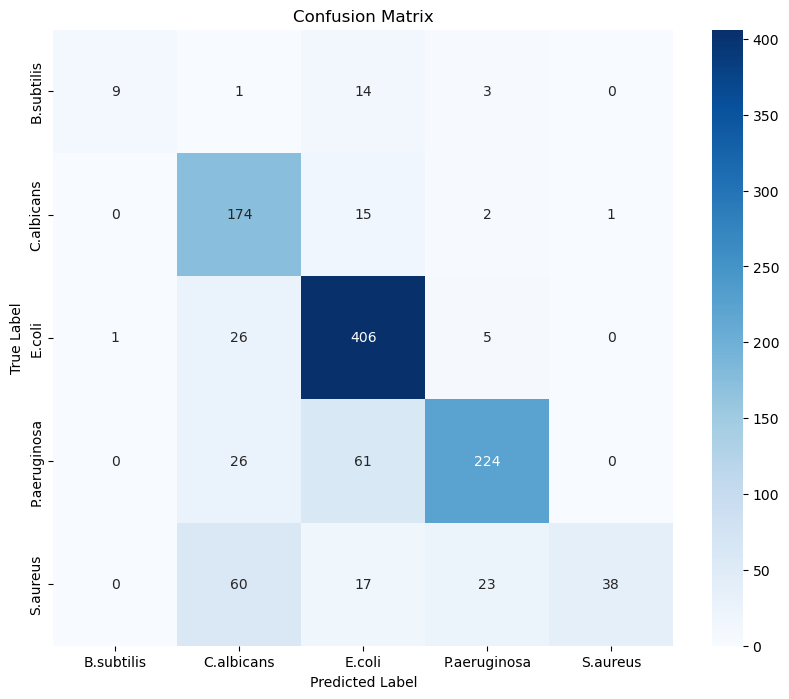

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualise the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtain probability forecasts from the model
val_predictions_prob = model.predict(np.array(val_images))

35/35 [==============================] - 7s 187ms/step


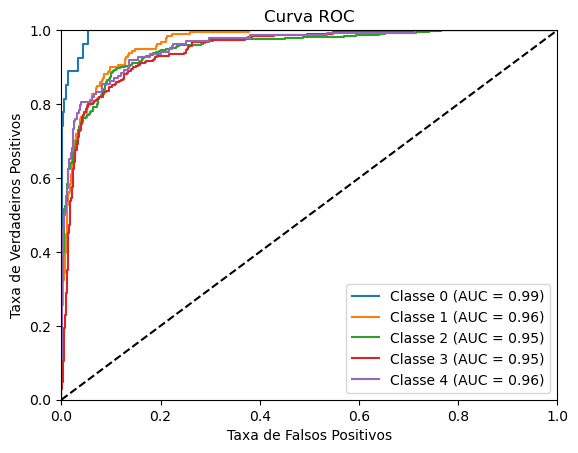

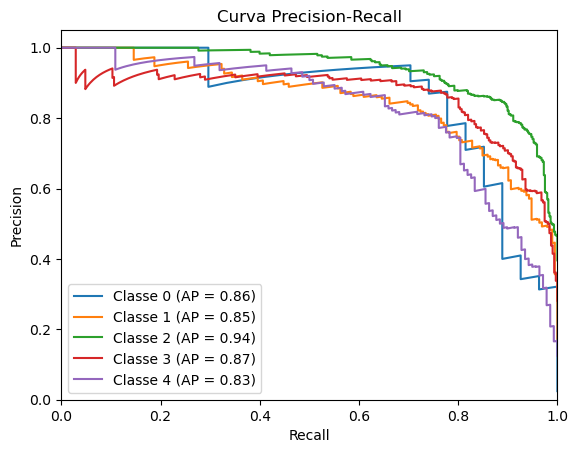

In [35]:
# Number of classes
n_classes = val_labels_one_hot.shape[1]

# Roc curves
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(val_labels_one_hot[:, i], val_predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#Precision-Recall and Average Precision curves
precision = dict()
recall = dict()
pr_auc = dict()
ap = dict()  # Dictionary to store the AP

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(val_labels_one_hot[:, i], val_predictions_prob[:, i])
    pr_auc[i] = auc(recall[i], precision[i])
    ap[i] = average_precision_score(val_labels_one_hot[:, i], val_predictions_prob[:, i])  # Calcular AP

# Plot the Precision-Recall curve
plt.figure()
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Classe {i} (AP = {ap[i]:.2f})')  # Exibir AP no label
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower left")
plt.show()